In [368]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, t
import scipy
import matplotlib.pyplot as plt

In [286]:
class european_option:
    
    def __init__(self, spot, strike, rate, sigma, time, kind):
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.sigma = sigma
        self.time = time
        self.kind = kind
        
        self.d_1 = (math.log(self.spot / self.strike) + (self.rate + self.sigma ** 2 / 2) * self.time) / (self.sigma * math.sqrt(self.time))
        self.d_2 = self.d_1 - self.sigma * math.sqrt(self.time)
        
    def price(self):
        if self.kind == "Call":
            price = self.spot * norm.cdf(self.d_1) - self.strike * math.exp(-self.rate * self.time) * norm.cdf(self.d_2)
        elif self.kind == "Put":
            price = self.strike * math.exp(-self.rate * self.time) * norm.cdf(-self.d_2) - self.spot * norm.cdf(-self.d_1)
        else:
            raise ValueError("Unavailable kind of option")
        return price
    
    def delta(self):
        if self.kind == "Call":
            delta = norm.cdf(self.d_1)
        elif self.kind == "Put":
            delta = norm.cdf(self.d_1) - 1
        else:
            raise ValueError("Unavailable kind of option")
        return delta
    
    def gamma(self):
        gamma = norm.pdf(self.d_1) / (self.spot * self.sigma * math.sqrt(self.time))
        return gamma
    
    def vega(self):
        vega = self.spot * norm.pdf(self.d_1) * math.sqrt(self.time)
        return vega
    
    def rho(self):
        rho = self.strike * self.time * math.exp(-self.rate * self.time) * norm.cdf(self.d_2)
        return rho
    
    def theta(self):
        if self.kind == "Call":
            theta = (-(self.spot * norm.pdf(self.d_1) * self.sigma) / (2 * math.sqrt(self.time)) - 
                     self.rate * self.strike * math.exp(-self.rate * self.time) * norm.cdf(self.d_2)) / self.time
        elif self.kind == "Put":
            theta = (-(self.spot * norm.pdf(self.d_1) * self.sigma) / (2 * math.sqrt(self.time)) + 
                     self.rate * self.strike * math.exp(-self.rate * self.time) * norm.cdf(-self.d_2)) / self.time
        else:
            raise ValueError("Unavailable kind of option")
        return theta
    
class underlying:
    
    def __init__(self, spot):
        self.spot = spot
        
    def price(self):
        return self.spot
    
    def delta(self):
        return 1
    
    def gamma(self):
        return 0
    
    def vega(self):
        return 0
    
    def rho(self):
        return 0
    
    def theta(self):
        return 0
    
class european_binary_option:
    
    def __init__(self, spot, strike, rate, sigma, time, kind):
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.sigma = sigma
        self.time = time
        self.kind = kind
        
        self.d_1 = (math.log(self.spot / self.strike) + (self.rate + self.sigma ** 2 / 2) * self.time) / (self.sigma * math.sqrt(self.time))
        self.d_2 = self.d_1 - self.sigma * math.sqrt(self.time)
        
        self.phi = (self.kind == "Call") - (self.kind == "Put") 
        # Analytical formulas for digital option's greeks are from https://quantpie.co.uk/bsm_bin_c_formula/bs_bin_c_summary.php
        
    def price(self):
        # legacy code just to make sure that pricing is consistent
        # for more details regarding digital options approximation see
        # Mohamed Bouzoubaa, Adel Osseiran - Exotic_Options and_Hybrids: A Guide
        return math.exp(-self.rate * self.time) * norm.cdf(self.phi * self.d_2)
    
    def price_spread(self):
        return self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).price() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).price())
    
    def delta(self):
        return self.phi * math.exp(-self.rate * self.time) / (self.spot * self.sigma * math.sqrt(self.time)) * norm.pdf(self.d_2)
    
    def delta_spread(self):
        return self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).delta() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).delta())
    
    def gamma(self):
        return -self.phi * math.exp(-self.rate * self.time) / ((self.spot * self.sigma * math.sqrt(self.time)) ** 2) * norm.pdf(self.d_2) * self.d_1
    
    def gamma_spread(self):
        return self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).gamma() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).gamma())
    
    def vega(self):
        return -self.phi * math.exp(-self.rate * self.time) / self.sigma * self.d_1 * norm.pdf(self.d_2)
    
    def vega_spread(self):
        return self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).vega() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).vega())
    
    def rho(self):
        return self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).rho() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).rho())
    
    def theta(self):
        return 1 / self.time * self.phi * 1 / (2 * 0.0001) * (european_option(self.spot, self.strike - 0.0001, self.rate, self.sigma, self.time, self.kind).theta() -
                                   european_option(self.spot, self.strike + 0.0001, self.rate, self.sigma, self.time, self.kind).theta())
        
class european_barrier_option:
    
    def __init__(self, spot, strike, barrier, rate, sigma, time, kind, barrier_kind):
        self.spot = spot
        self.strike = strike
        self.barrier = barrier
        self.rate = rate
        self.sigma = sigma
        self.time = time
        self.kind = kind
        self.barrier_kind = barrier_kind
        
    def price(self):
        if self.kind == "Call" and self.barrier_kind == "Out":
            # It is actually correct!
            return (european_option(self.spot, self.strike, self.rate, self.sigma, self.time, self.kind).price() -
                    european_option(self.spot, self.barrier, self.rate, self.sigma, self.time, self.kind).price() -
                    european_binary_option(self.spot, self.barrier, self.rate, self.sigma, self.time, self.kind).price_spread() * (self.barrier - self.strike))

    def price_MC(self, I):                
        data = np.zeros((I, 2))
        z = np.random.normal(0, 1, [1, I])
        ST = self.spot*np.exp((self.time)*(self.rate - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.time)*z)
        data[:,1] = ST - self.strike
        
        if self.kind == "Call" and self.barrier_kind == "Out":
            average = np.sum(np.amax(data, axis=1) * (ST < self.barrier))/float(I)
            return np.exp(-self.rate*(self.time))*average
        
class reader:
    
    def __init__(self, filepath):
        self.filepath = filepath
        
    def portfolio_reader(self):
        file = pd.read_excel(self.filepath)
        lst_amounts = []
        lst_assets = []
        for i in range(len(file)):
            if file.iloc[i, 1] == "european_option":
                lst_assets.append(european_option(file.iloc[i, 2], file.iloc[i, 3], file.iloc[i, 4],
                                                  file.iloc[i, 5], file.iloc[i, 6], file.iloc[i, 7]))
            elif file.iloc[i, 1] == "underlying":
                lst_assets.append(underlying(file.iloc[i, 2]))
                
            elif file.iloc[i, 1] == "european_binary_option":
                lst_assets.append(european_binary_option(file.iloc[i, 2], file.iloc[i, 3], file.iloc[i, 4],
                                                  file.iloc[i, 5], file.iloc[i, 6], file.iloc[i, 7]))
                
            else:
                raise ValueError("Unavailable type of asset")
            if file.iloc[i, 8] == file.iloc[i, 8]:
                lst_amounts.append(file.iloc[i, 8])
            else:
                raise ValueError("Wrong weight!")
        return [lst_assets, lst_amounts]
    
    def market_data_reader(self):
        RVI = pd.read_excel(self.filepath, 0)
        stock = pd.read_excel(self.filepath, 1)
        
        rvi_time_series = RVI.iloc[:,1]
        stock_time_series = stock.iloc[:,1]
        
        rvi_returns = rvi_time_series.pct_change(1)[1:]
        stock_returns = stock_time_series.pct_change(1)[1:]
        
        return [rvi_returns, stock_returns, rvi_time_series, stock_time_series]
    
class portfolio:
    
    def __init__(self):
        self.lst_assets = reader("portfolio.xlsx").portfolio_reader()[0]
        self.lst_amounts = reader("portfolio.xlsx").portfolio_reader()[1]
        self.weights = list(np.array(self.lst_amounts) / np.array(self.lst_amounts).sum())
        
    def price(self):
        return np.array(self.lst_amounts).sum()
    
    def delta(self):
        sum = 0
        for i in range(len(self.lst_assets)):
            sum += self.lst_assets[i].delta() * self.weights[i]
        return sum
        
    def gamma(self):
        sum = 0
        for i in range(len(self.lst_assets)):
            sum += self.lst_assets[i].gamma() * self.weights[i]
        return sum
    
    def vega(self):
        sum = 0
        for i in range(len(self.lst_assets)):
            sum += self.lst_assets[i].vega() * self.weights[i]
        return sum
    
    def rho(self):
        sum = 0
        for i in range(len(self.lst_assets)):
            sum += self.lst_assets[i].rho() * self.weights[i]
        return sum
    
    def theta(self):
        sum = 0
        for i in range(len(self.lst_assets)):
            sum += self.lst_assets[i].theta() * self.weights[i]
        return sum

In [225]:
reader("portfolio.xlsx").portfolio_reader()

[[<__main__.underlying at 0x17515657d90>,
 [1000000, 350000, -350000, -350000, 800000, -300000]]

In [226]:
print(f"Value of a portfolio: {portfolio().price()} \nDelta of a portfolio: {round(portfolio().delta(),5)} \nGamma of a portfolio: {round(portfolio().gamma(),5)} \nVega of a portfolio: {round(portfolio().vega(),5)} \nTheta of a portfolio: {round(portfolio().theta(),5)} \nRho of a portfolio: {round(portfolio().rho(),5)}")

Value of a portfolio: 1150000 
Delta of a portfolio: 0.80608 
Gamma of a portfolio: 0.00026 
Vega of a portfolio: 306.67314 
Theta of a portfolio: -69.48511 
Rho of a portfolio: 438.34688


## Now, lets make use of these portfolio sensitivities

Delta approach:

In [354]:
h = portfolio()
stock_returns = np.array(reader("market_data.xlsx").market_data_reader()[1])
PnL_returns_delta = h.price() * h.delta() * stock_returns
PnL_returns_delta[0]

18502.609969526715

Delta-Gamma approach:

In [300]:
PnL_returns_delta_gamma = h.price() * (h.delta() * stock_returns + 
                                       h.gamma() / 2 *  stock_returns ** 2)
PnL_returns_delta_gamma[0]

16949.150609128857

Delta-Gamma-Vega approach:

In [362]:
rvi_returns = np.array(reader("market_data.xlsx").market_data_reader()[0])
PnL_returns_delta_gamma_vega = h.price() * (h.delta() * stock_returns + 
                                            h.gamma() / 2 *  stock_returns ** 2) + h.vega() * rvi_returns
PnL_returns_delta_gamma_vega[0]

18499.90925917689

Full revaluation approach:

In [378]:
portfolio_representation = reader("portfolio.xlsx").portfolio_reader()
market_data = reader("market_data.xlsx").market_data_reader()

aggregate_instument_values = []

for i in range(len(portfolio_representation[0])):
    if portfolio_representation[0][i].__class__.__name__ == 'european_option':
        instrument_values = []
        original_number = portfolio_representation[1][i] / portfolio_representation[0][i].price()
        for j in range(1, len(market_data[3])):
            
            new_price = european_option(market_data[3][j], portfolio_representation[0][i].strike, portfolio_representation[0][i].rate, 
                                        market_data[2][j] / 100, portfolio_representation[0][i].time, portfolio_representation[0][i].kind).price()

            old_price = european_option(market_data[3][j-1], portfolio_representation[0][i].strike, portfolio_representation[0][i].rate, 
                                        market_data[2][j-1] / 100, portfolio_representation[0][i].time, portfolio_representation[0][i].kind).price()
            
            instrument_values.append(original_number * (new_price - old_price))  
            
        aggregate_instument_values.append(instrument_values)
        
    elif portfolio_representation[0][i].__class__.__name__ == 'european_binary_option':
        instrument_values = []
        original_number = portfolio_representation[1][i] / portfolio_representation[0][i].price()
        for j in range(1, len(market_data[3])):
            
            new_price = european_binary_option(market_data[3][j], portfolio_representation[0][i].strike, portfolio_representation[0][i].rate, 
                                        market_data[2][j] / 100, portfolio_representation[0][i].time, portfolio_representation[0][i].kind).price()

            old_price = european_binary_option(market_data[3][j-1], portfolio_representation[0][i].strike, portfolio_representation[0][i].rate, 
                                        market_data[2][j-1] / 100, portfolio_representation[0][i].time, portfolio_representation[0][i].kind).price()
            
            instrument_values.append(original_number * (new_price - old_price))  
            
        aggregate_instument_values.append(instrument_values)
        
    else:
        instrument_values = []
        original_number = portfolio_representation[1][i] / portfolio_representation[0][i].price()
        for j in range(1, len(market_data[3])):
            new_price = underlying(market_data[3][j]).price()
            old_price = underlying(market_data[3][j-1]).price()
            instrument_values.append(original_number * (new_price - old_price))
        aggregate_instument_values.append(instrument_values)   
        
PnL_returns_full_reval = pd.DataFrame(aggregate_instument_values).sum(axis = 0)

In [352]:
pd.DataFrame(aggregate_instument_values)

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,10802.003500,-4043.208014,1870.738036,6276.024380,2293.162754,5672.560497,-19009.112305,4043.208014,-3379.397743,-3379.397743,...,18586.687587,65294.792107,-5672.560497,-4767.364673,4284.593567,52018.586688,-11345.120995,1448.313318,-8207.108805,-31018.043570
1,-5621.297523,-27937.883260,-4767.106844,10192.686022,17154.519112,-16138.842727,-12863.461723,-6551.579970,-15639.925429,-19243.555935,...,28768.027564,39308.540063,-30423.294908,40804.554486,77749.759883,92943.093316,-36687.074573,32327.336495,-18707.586824,-50212.254813
2,6816.868422,31296.754495,5339.830089,-11124.507585,-19196.434036,18328.054743,13684.073717,7313.113485,16821.454646,19912.335061,...,-29031.121657,-25453.599658,33954.955896,-50799.709521,-92987.323298,-94827.684676,41227.783699,-40363.018058,20074.161523,50721.095100
3,715.904964,14186.265233,2451.576979,-6385.961312,-8809.844785,7226.891209,9457.631870,3493.240292,10889.023784,16561.594080,...,-28324.421054,-92578.474233,19414.560176,-5960.195078,-20220.522779,-88260.994606,19443.235650,-438.428598,13703.404406,49585.062329
4,-102250.826324,-10051.640068,-24094.813804,-37959.197665,8233.790500,-75634.563127,144355.327977,-46111.064452,3928.223894,-2275.747388,...,-40605.826106,-143389.988849,-5020.624714,28339.912525,46189.493112,-58742.444078,1748.702078,14509.732856,6389.840737,43984.284718
5,350501.155826,215343.810350,110605.565820,40578.412399,-137739.614232,335805.125084,-345686.448717,196372.268836,139303.738542,272889.635956,...,21985.614899,68695.092712,1042.146175,-7327.927023,-32581.128290,30818.772363,464.954848,-9631.540661,-2943.595769,-27878.917135


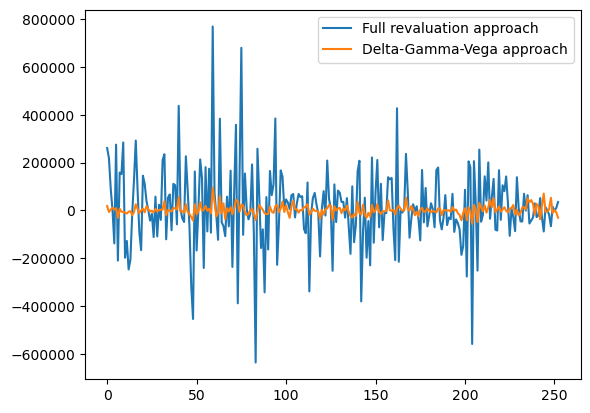

In [380]:
plt.plot(np.arange(0,len(PnL_returns_full_reval)), PnL_returns_full_reval, label = "Full revaluation approach")
plt.plot(np.arange(0,len(PnL_returns_delta)), PnL_returns_delta_gamma_vega, label = "Delta-Gamma-Vega approach")
# plt.plot(np.arange(0,len(PnL_returns_delta)), PnL_returns_delta, label = "Delta approach")
plt.legend()

In [73]:
print(european_barrier_option(100, 110, 120, 0.1, 0.15, 1, "Call", "Out").price_MC(1000000))
print(european_barrier_option(100, 110, 120, 0.1, 0.15, 1, "Call", "Out").price())


0.9317614993231618
0.9326104777871009


In [373]:
print(european_binary_option(100, 110, 0.1, 0.15, 1, "Call").vega())
print(european_binary_option(100, 110, 0.1, 0.15, 1, "Call").delta_spread())

-0.25548545365070735
0.024042189672446312


# VaR

### Historic

In [365]:
VaR = -np.quantile(PnL_returns_full_reval, .05)
VaR

238369.11630367194

### Parametric (Normal)

In [367]:
VaR = -norm.ppf(.05, PnL_returns_full_reval.mean(), PnL_returns_full_reval.std())
VaR

258571.79818777388

### Parametric (Student)

In [369]:
VaR = -t.ppf(.05, len(PnL_returns_full_reval) - 1, PnL_returns_full_reval.mean(), PnL_returns_full_reval.std())
VaR

259569.4255044755